### Final Story Telling
The final iteration of the Create Your Own Ending Project covers the entire process of the Project. We explore the data set and explain the logic behind why we alter the data the way we do, how the algorithms fit the data, and our faring against others once our model is submitted on Kaggle.

Below we import all of the modules and libraries we use.

In [2]:
# Import needed for Data Exploration and Algorithm Developing\

# Import Useful for plotting
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import seaborn as sns
from sklearn import preprocessing

# Changing and importing data
import pandas as pd
import numpy as np
import zipfile

# Machine Learning Modules
import sklearn as sk
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn import cross_validation
from sklearn.cross_validation import KFold
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import export_graphviz
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
import scipy as sp

%matplotlib inline

/home/tj/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


### Exploration

In this section, we explore data using many different methods. We both check the structure of the data and the content of the data, heavily depending on visual aids. Overall, we attempt to visualize as much of the data as possible and have some insight on which components of the data sets we want to utilize and which we want to leave out.

We import the training and testing data for the SF Crime data.

In [3]:
#importing train dataset
z_train = zipfile.ZipFile('train.csv.zip')
train = pd.read_csv(z_train.open('train.csv'), parse_dates=['Dates'], index_col=False)

#### Initial Observations of the Data Set

After we load the data set, we observe each of the columns to observe if there are any NaN values we must deal with, and just get the gist of what we are working with.

All the entries for the train.csv are non-null values. However, there might be NONE entries within the Category column. Overall, we believe that the data is thorough and reliable and not much modification needs to be done to get rid of NaN values. We run a similar check for the test data.

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 878049 entries, 0 to 878048
Data columns (total 9 columns):
Dates         878049 non-null datetime64[ns]
Category      878049 non-null object
Descript      878049 non-null object
DayOfWeek     878049 non-null object
PdDistrict    878049 non-null object
Resolution    878049 non-null object
Address       878049 non-null object
X             878049 non-null float64
Y             878049 non-null float64
dtypes: datetime64[ns](1), float64(2), object(6)
memory usage: 67.0+ MB


In [5]:
#importing test dataset
z_test = zipfile.ZipFile('test.csv.zip')
test = pd.read_csv(z_test.open('test.csv'), parse_dates=['Dates'], index_col=False)
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 884262 entries, 0 to 884261
Data columns (total 7 columns):
Id            884262 non-null int64
Dates         884262 non-null datetime64[ns]
DayOfWeek     884262 non-null object
PdDistrict    884262 non-null object
Address       884262 non-null object
X             884262 non-null float64
Y             884262 non-null float64
dtypes: datetime64[ns](1), float64(2), int64(1), object(3)
memory usage: 54.0+ MB


All the entries for the test.csv are non-null values. We observe that the test data do not hold the columns of Resolution, Category, and Descript. The Resolution and Descript will therefore not be useful to our algorithms.

Below, the description for each column of the data set is given.

""" dataset contains incidents derived from SFPD Crime Incident Reporting system The data ranges from 1/1/2003 to 5/13/2015 The training set and test set rotate every week (odd weeks belong to test set and even weeks belong to training set) 

[List order] Data Field Description 

[0] Id 

[1] Dates timestamp of the crime incident 

[2] DayOfWeek the day of the week 

[3] PdDistrict name of the Police Department District 

[4] Address the approximate street address of the crime incident 

[5] X Longitude 

[6] Y Latitude 

[7] Category (target variable) category of the crime incident (only in train.csv) 

[8] Descript detailed description of the crime incident (only in train.csv) 

[9] Resolution how the crime incident was resolved (only in train.csv) """

As we know what the columns are in the data set, we want to explore how many unique types are in the columns. Some key columns in our data set take the form of categorical values such as Category, Address, and PdDistrict. We want to check whether or not there are too many categories within each column, as too many categories render an algorithm meaningless, as the input data becomes too specific.

In [6]:
# Checking total number of unique data in each column of data set
print 'total no. of cases: ', len(train)
for field in train:
    if field in ['Id']:
        continue
    else:
        print 'no. of unique data in ' + field + ':', len(train[field].unique())

total no. of cases:  878049
no. of unique data in Dates: 389257
no. of unique data in Category: 39
no. of unique data in Descript: 879
no. of unique data in DayOfWeek: 7
no. of unique data in PdDistrict: 10
no. of unique data in Resolution: 17
no. of unique data in Address: 23228
no. of unique data in X: 34243
no. of unique data in Y: 34243


We observe that the Address has 23228 diffrent categorial values and therefore can lead to overfitting.

#### Visually Observing Data Trends with Maps

We now overlaid all the crimes upon the SF map to see if the data had any real discreptancies. Initially we import the map data and set boundaries on which crimes we want to examine.

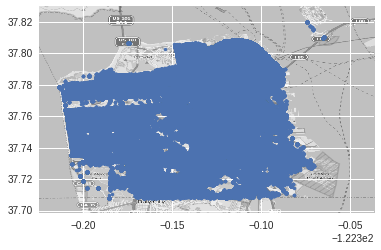

In [7]:
#importing map
mapdata = np.loadtxt('sf_map_copyright_openstreetmap_contributors.txt')
asp = mapdata.shape[0] * 1.0 / mapdata.shape[1]

ll_lon, ll_lat = -122.52469, 37.69862
ur_lon, ur_lat = -122.33663, 37.82986


#cleaning data 
train['Xc'] = train[(train.X < ur_lon) & (train.X > ll_lon)].X
train['Yc'] = train[(train.Y < ur_lat) & (train.Y > ll_lat)].Y
train = train.dropna(subset = ['Xc', 'Yc'])

#plotting all datapoints
plt.imshow(mapdata, cmap=plt.get_cmap('gray'), extent=[ll_lon, ur_lon, ll_lat, ur_lat], aspect=asp)
plt.plot(train['Xc'],train['Yc'],'.')
plt.axis([ll_lon, ur_lon, ll_lat, ur_lat])
plt.show()

From what we see we can successfully utilize the map tool to overlay crimes upon the city. We want to explore trends of how different crime Categories occur throughout the city, and how the different PD districts respond to different parts of the city.

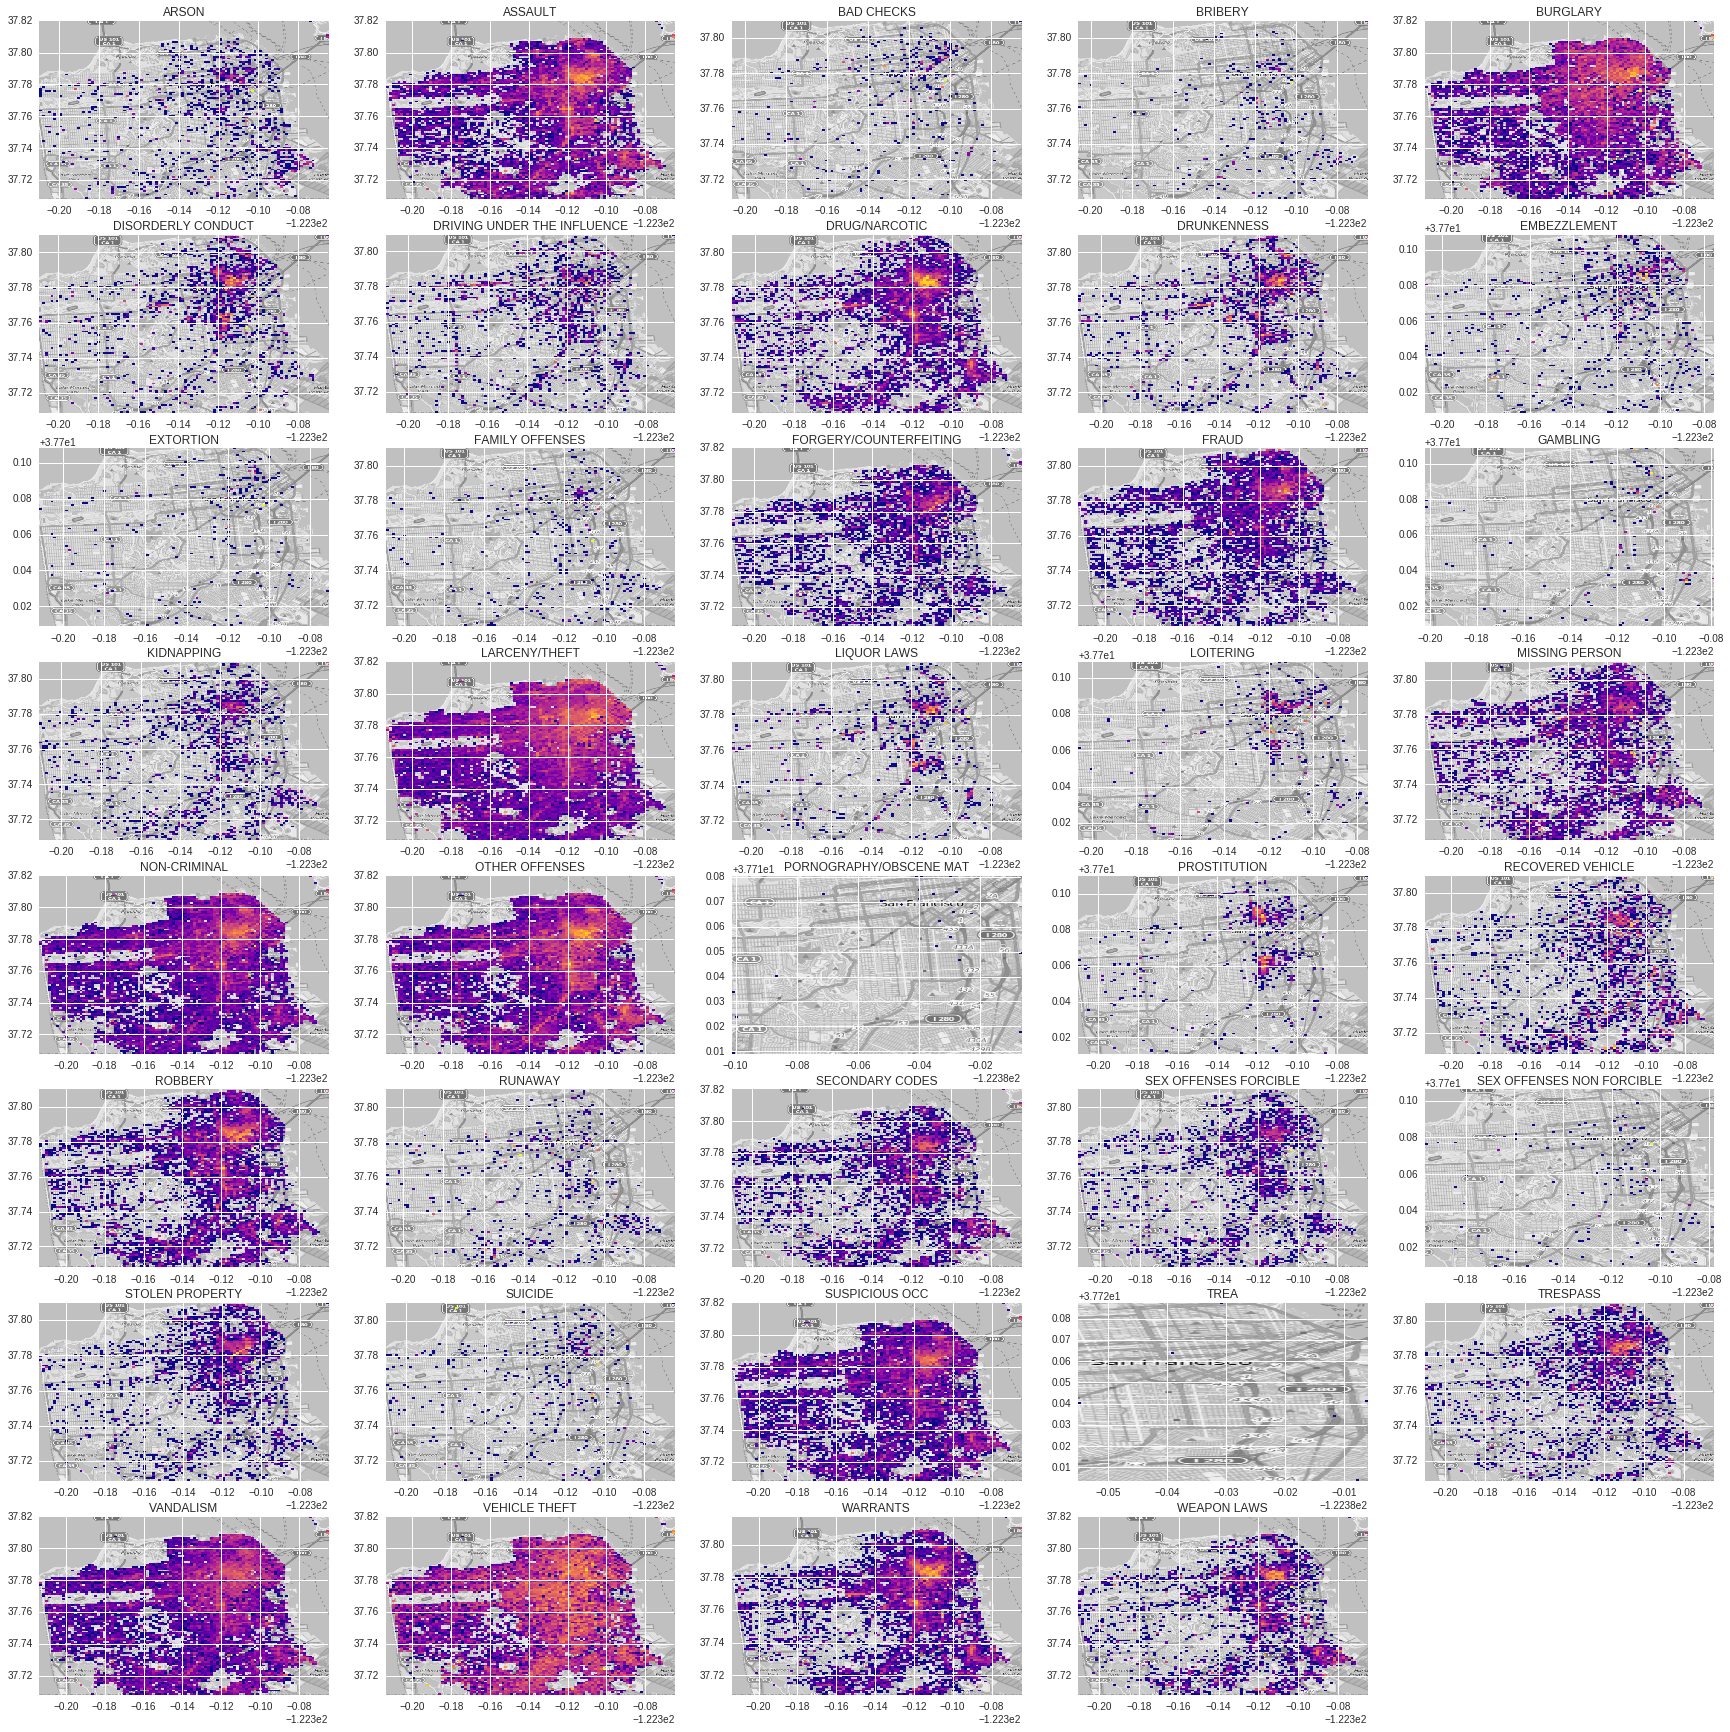

In [8]:
# Function for Plotting Column onto SF Map
def plot_on_map_by_fields(df, field):
    """
    function takes in dataframe(df) and the field
    and plots over the map after grouping by unique data in field
    """
    groups = df.groupby(field)
    i=1
    plt.figure(figsize=(30, 30))
    for name, group in groups:
        plt.subplot(8,5,i)
        histo, xedges, yedges = np.histogram2d(np.array(group.Xc),np.array(group.Yc), bins=(100, 100))
        myextent  =[xedges[0],xedges[-1],yedges[0],yedges[-1]]
        plt.imshow(mapdata, cmap=plt.get_cmap('gray'), extent=[ll_lon, ur_lon, ll_lat, ur_lat], aspect=asp)
        plt.imshow(histo.T,origin='low',extent=myextent,interpolation='nearest',aspect='auto',norm=LogNorm(), cmap = 'plasma')
        plt.title(name)
        i+=1
    return

# Plot on map for Crime Category
plot_on_map_by_fields(train, 'Category')

It is difficult to see obvious trends from here. Most of the crime seems to be heavily focused on the NE part of the city, but crime intensity varies greatly from crime to crime. Now we do the same for PD Districts.

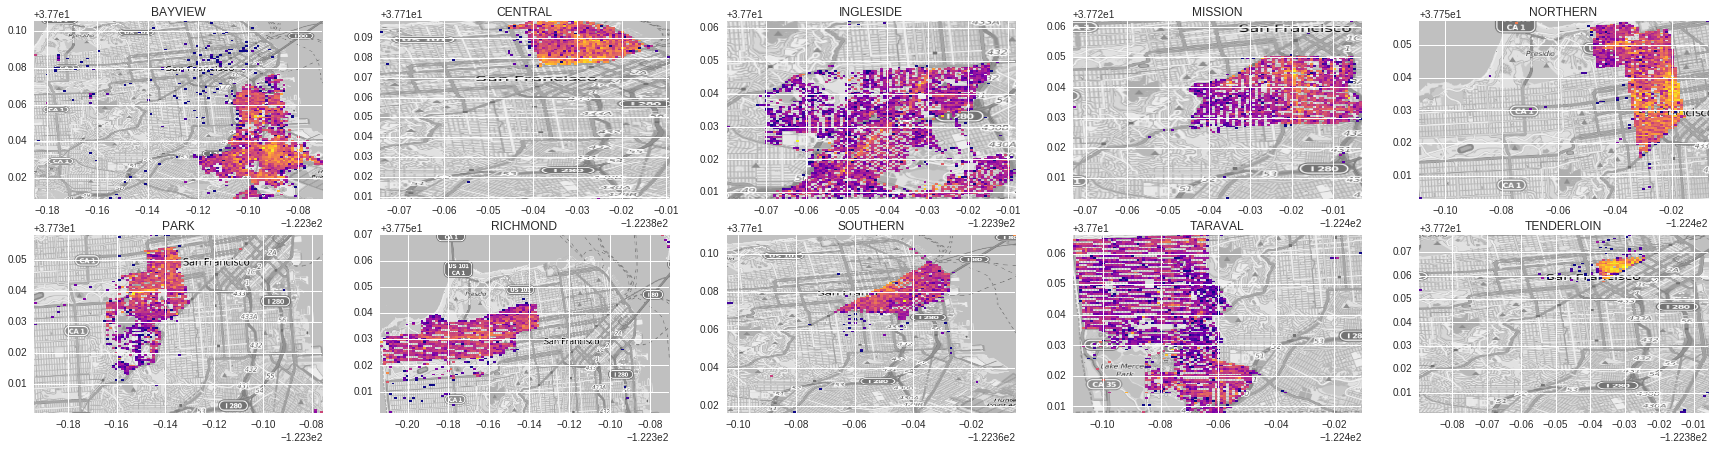

In [9]:
# Plot for PdDistrict over SF Map
plot_on_map_by_fields(train, 'PdDistrict')

The PdDistrict shows very definite trends. It reflects how specific Police departments only operate in specific areas of the city which makes sense. The differentiation brought by the PdDistrict data will probably be more useful than that of the Crime Categories as they do not have so many different categories, which may help prevent overfitting.

#### Visually Observing Using Line Graphs and Histograms
With the mapping observations complete, we move on to observing different trends and correlations within the data. Here we utilize Seaborn to graph different categories and see if there are relations to crime rates. These include analysis on crimes per day, crimes during different hours of the day, different days of the week and so forth. Moreover, we observe different crime rates in districts.

In [10]:
# Function for altering Data Set Columns
def time_trim(df):
    df['Day'] = df['Dates'].dt.day
    df['Month'] = df['Dates'].dt.month
    df['Year'] = df['Dates'].dt.year
    df['Hour'] = df['Dates'].dt.hour
    df['Minute'] = df['Dates'].dt.minute
    df['WeekOfYear'] = df['Dates'].dt.weekofyear
    return

time_trim(train)

# Functions for creating histograms and lie graphs
colors = ('husl', 'coolwarm', 'RdYlGn', 'Greens', 'Blues')
def plot_histogram(df, field):
    df[field].value_counts().plot(kind='bar', figsize=(8,10), 
                                  title=('Number of Crimes by '+ field), 
                                  color = sns.color_palette(np.random.choice(colors), len(df[field].unique())))
    return

def plot_ordered_histogram(df, field):
    df['event']=1
    events = df[[field,'event']].groupby([field]).count().reset_index()
    events.plot(kind='bar', title=('Number of Crimes by '+ field))
    return

def plot_ordered_histogram2(df, field1, field2):
    """
    index: field1
    columns: field2
    """
    df['event']=1
    events = train[[field1, field2,'event']].groupby([field1, field2]).count().reset_index()
    events_pivot = events.pivot(index=field1, columns=field2, values='event').fillna(method='ffill')
    events_pivot.interpolate().plot(title=('number of cases by ' + field1 + ' & ' + field2), figsize=(15,10))

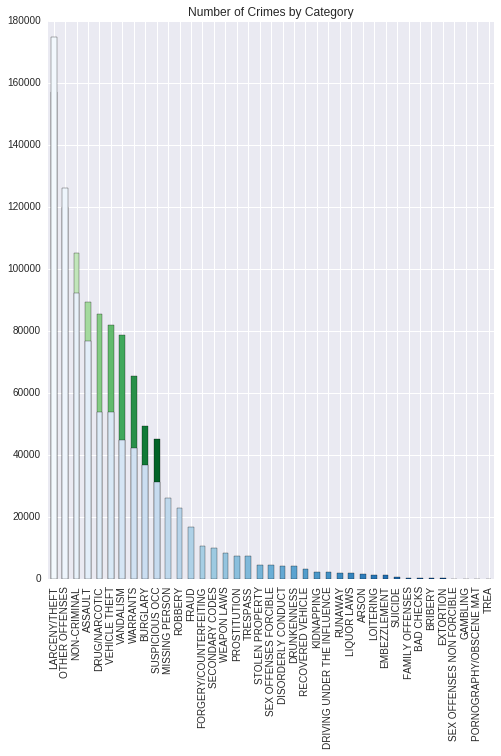

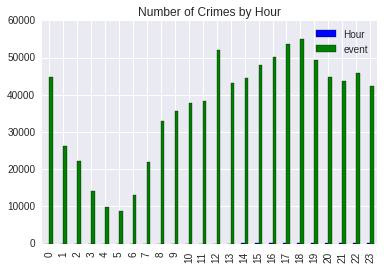

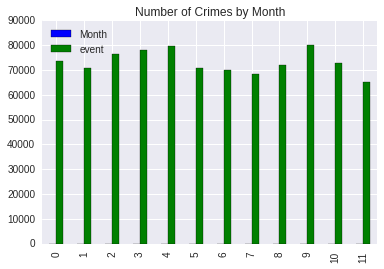

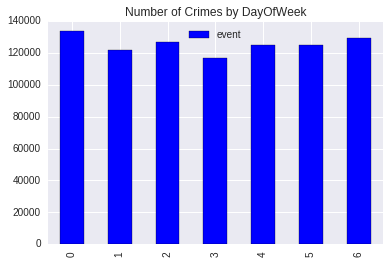

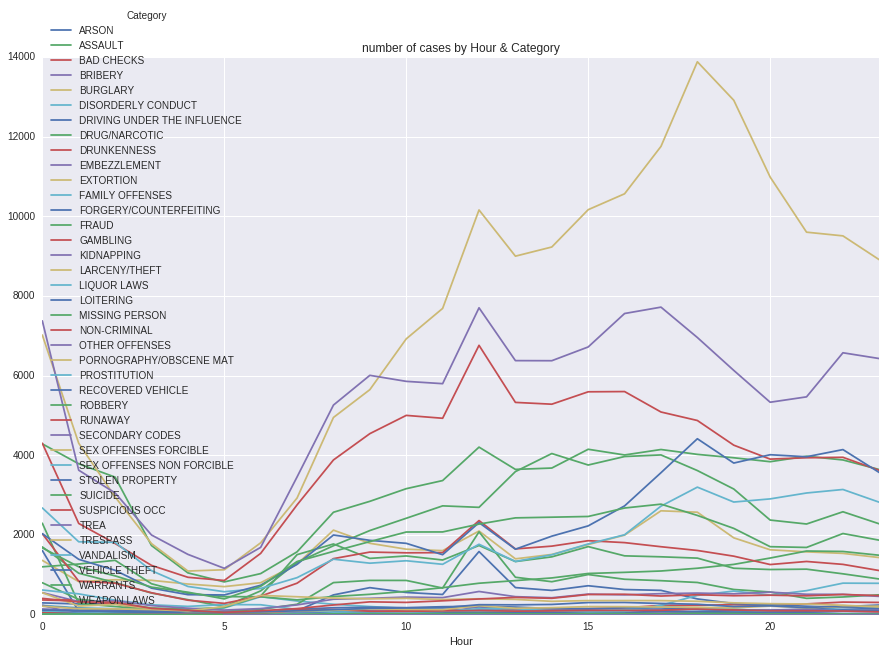

In [11]:
plot_histogram(train, 'PdDistrict')
plot_histogram(train, 'Category')
plot_ordered_histogram(train, 'Hour')
plot_ordered_histogram(train, 'Month')
plot_ordered_histogram(train, 'DayOfWeek')
plot_ordered_histogram2(train, 'Hour', 'Category')

After viewing the graphs presented below, it is obvious that there are some trends, some districts more crime heavy than others, some crime types specific to districts and so on. The data columns of crime type, the different components of time, and area, seem to have many relations with each other over time. However, at the same time, the data across the maps seem to be all over the place. Although all the crimes have a strong correlation with time of day throughout, this does not help differentiate between the crimes and that is why we use a log loss system for our algorithm grading, which is explained below.

### Short Word on Log Loss Systems on Kaggle

Unlike the standard grading system in Kaggle, which just returns the % accuracy of the output csv files, the log loss system returns the sum of errors from the output csv file. When the algorithms are run in the SF Crime Kaggle test, each tested crime event has 39 probabilities assigned to it, one for each crime category. All the probabilities add up to 1, and each probability reflects how plausible it is for the crime categories to happen relative to the other crime categories.

When generating the log loss value for the test, Kaggle goes through each crime event, and takes the log of the probability of the correct crime category. For example, for a crime event of a Robbery, if the probability assigned by the algorithm was 1, the penalty error value would be -log(1) which is zero. if the probabilty assigned was 0.1, the penalty error value would be -log(0.1), which is 1. Kaggle goes through each of the crime events and accumulates the error. 

Therefore, we want to minimize the total error by optimizing our algorithm. Log loss systems work well especially when the output is a categorical values with many potential categories. Unlike the Titanic Kaggle activity, where the output was either rounded to 0 or 1, the log loss system rewards the tweaking of algorithms as it tracks small changes in each of the probability.

### Data Tools and Manipulation

The information in some of the columns in the data are extracted & seperated into different columns for better evaluation.

The time_trim function converts total Date column into sub parts for convenience.

The make_seasons function converts month data into seasons which we can include in our approximation. However, seasons overlap with date greatly, so we may not fully utilize it.


The few following lines allows us to create dummy variables with data from pre-existing columns. Dummy variables work extremely well with Random Forrest Regression, although the number of columns in the data set are increased. This will probably be used for randomforest or gradient boosting method.

In [12]:
def time_trim(df):
    df['Day'] = df['Dates'].dt.day
    df['Month'] = df['Dates'].dt.month
    df['Year'] = df['Dates'].dt.year
    df['Hour'] = df['Dates'].dt.hour
    df['Minute'] = df['Dates'].dt.minute
    df['WeekOfYear'] = df['Dates'].dt.weekofyear
    return

def make_season(df):
    """
    Make new field name Season
    and binary fields for each season
    Has to happen after making 'Month' field
    spring: month 2, 3, 4
    summer: month 5, 6, 7
    autumn: month 8, 9, 10
    winter: month 11, 12, 1
    """
    df['Season'] = df['Month']
    df.loc[(df['Season'] > 10) | (df['Season'] == 1), 'Season'] = 'Winter'
    df.loc[(df['Season'] > 1) & (df['Season'] <= 4), 'Season'] = 'Spring'
    df.loc[(df['Season'] > 4) & (df['Season'] <= 7), 'Season'] = 'Summer'
    df.loc[(df['Season'] > 7) & (df['Season'] <= 10), 'Season'] = 'Autumn'
    return

# Applying above functions to data set
#time_trim(train)
seasons = make_season(train)

time_trim(test)
seasons = make_season(test)

#Making into binary
train = pd.concat((train, pd.get_dummies(train['DayOfWeek'], prefix = 'dow')), axis=1)
train = pd.concat((train, pd.get_dummies(train['Season'], prefix = 'season')), axis=1)
train = pd.concat((train, pd.get_dummies(train['PdDistrict'], prefix = 'pdd')), axis=1)

test = pd.concat((test, pd.get_dummies(test['DayOfWeek'], prefix = 'dow')), axis=1)
test = pd.concat((test, pd.get_dummies(test['Season'], prefix = 'season')), axis=1)
test = pd.concat((test, pd.get_dummies(test['PdDistrict'], prefix = 'pdd')), axis=1)

An alternative to binaries is encoding our categorical values. When Encoding, each categorical variable will have its sub-categories replaced with numbers compared to strings. For example, for weekdays, instead of having 7 dummie variables holding 0 or 1 depending on if it is a certain day, there will be one column called dayofweek that will hold values 0 to 6, each number representing a day of week.

Encoding may be useful as we work with overall less columns in our data set. However, the encoded values which are now intergers may form a continuum, fitting itself in a weird way that is not categorical.

In [13]:
#Function encoding the categorial data columns in data set and adding it on 
def enc(df):
    enc_pdd = LabelEncoder()
    df['PdDistrict_enc'] = enc_pdd.fit_transform(df['PdDistrict'])

    enc_seas = LabelEncoder()
    df['Season_enc'] = enc_seas.fit_transform(df['Season'])

    enc_dow = LabelEncoder()
    df['DayOfWeek_enc'] = enc_dow.fit_transform(df['DayOfWeek'])
    return

enc(train)
enc(test)

# Encoding the output category, as we need to make values numbers to successfully run in sklearn algorithm
enc = LabelEncoder()
enc.fit(train['Category'])
train['CategoryEncoded'] = enc.transform(train['Category'])

In [14]:
# Observing new columns added by this process and generating predictor lists from columns
train.info()

predictors = ['Day','Month','Year','Hour','Minute','WeekOfYear']
predictors_b = ['pdd_TENDERLOIN', 'pdd_TARAVAL', 'pdd_SOUTHERN', 'pdd_RICHMOND', 'pdd_PARK', 
                'pdd_NORTHERN', 'pdd_MISSION', 'pdd_INGLESIDE', 'pdd_CENTRAL', 'pdd_BAYVIEW',
                'season_Winter', 'season_Summer', 'season_Spring', 'season_Autumn', 
                'dow_Friday', 'dow_Monday', 'dow_Tuesday', 'dow_Wednesday', 'dow_Thursday', 
                'dow_Saturday', 'dow_Sunday']
predictors_enc = ['PdDistrict_enc', 'Season_enc', 'DayOfWeek_enc']

<class 'pandas.core.frame.DataFrame'>
Int64Index: 877982 entries, 0 to 878048
Data columns (total 44 columns):
Dates              877982 non-null datetime64[ns]
Category           877982 non-null object
Descript           877982 non-null object
DayOfWeek          877982 non-null object
PdDistrict         877982 non-null object
Resolution         877982 non-null object
Address            877982 non-null object
X                  877982 non-null float64
Y                  877982 non-null float64
Xc                 877982 non-null float64
Yc                 877982 non-null float64
Day                877982 non-null int64
Month              877982 non-null int64
Year               877982 non-null int64
Hour               877982 non-null int64
Minute             877982 non-null int64
WeekOfYear         877982 non-null int64
event              877982 non-null int64
Season             877982 non-null object
dow_Friday         877982 non-null float64
dow_Monday         877982 non-null float64


### Algorithm Exploration Through Cross Validation

With the data set modified and ready to go, we developed a log loss scoring system for when we cross validate within our data. This portion includes dividing up our training set into sub categories for testing, and the testing of different algorithms.

In [15]:
# Logloss function used for determining log loss in cross validation
def logloss(y,p):
    """
    information derived from following sources
    https://www.kaggle.com/wiki/LogarithmicLoss
    https://www.kaggle.com/c/sf-crime/details/evaluation
    """
    eps = 1e-15
    p = p/p.sum(axis=1)[:,np.newaxis]
    p = np.maximum(eps,p)
    p = np.minimum(1-eps,p)
    

    # Calculate logloss
    ll = 0
    for i in range(len(p)):
        ll += np.log(p[i, y.iloc[i]])
    ll /= float(-len(p))

    return ll

In [16]:
# Separating Data within training set for cross validation

# Create x and y from train data, x will be train, y will be target
# sub labels b and e indicate whether the columns included are binary or encoded
x_b = train[predictors + predictors_b]
x_e = train[predictors + predictors_enc]
y = train['CategoryEncoded']

# Splitting data within training set for each of encoded and binary
xtr_b, xtest_b, ytr_b, ytest_b = cross_validation.train_test_split(x_b, y, train_size = 0.5)
xtr_e, xtest_e, ytr_e, ytest_e = cross_validation.train_test_split(x_e, y, train_size = 0.5)

#### Selecting Regression Methods to Use

The three types of regression we will use to cross validate the data is logistic, decision tree, and random forest. We did not use linear regression because a lot of the trends (like crime rate against hours, months) did not show much linear characteristics.

We tested out logistic regression, as it handles categorical analysis better than the linear process. A benefit of using logistic regression is that we can add altered penalty values. For greater error values we can square the error to penalize it greater. In our iteration, we don't do that as we want to explore different types of regression and not logistic alone.

Both decision tree and random forest methods are strong with categorical variables as they divide based upon if statements. Such tree methods do not need an implemented penalty system like the logistic regression. The random forest is a more advanced version of the decision tree, as it takes multiple decision tree outputs to combine and create a final algorithm. We suspect the random forest will yield the best results.

#### Logistic Method

In [17]:
# Logistic Methods
alg = LogisticRegression()
alg.fit(xtr_b, ytr_b)
prediction = alg.predict_proba(xtest_b)
print "binary logistic:", logloss(ytest_b,prediction)

binary logistic: 2.57750523957


In [18]:
alg = LogisticRegression()
alg.fit(xtr_e, ytr_e)
prediction = alg.predict_proba(xtest_e)
print "encoder logistic:", logloss(ytest_e,prediction)

encoder logistic: 2.62658195977


#### Random Forest Method

In [19]:
# Random Forest Methods
alg = RandomForestClassifier(max_depth=7)
alg.fit(xtr_b, ytr_b)
prediction = alg.predict_proba(xtest_b)
print "random forest binary max depth:", logloss(ytest_b,prediction)

random forest binary max depth: 2.54033933167


In [20]:
alg = RandomForestClassifier(max_depth=4, min_samples_split=2, min_samples_leaf=2)
alg.fit(xtr_b, ytr_b)
prediction = alg.predict_proba(xtest_b)
print "random forest binary max depth and min sample leaf/split:", logloss(ytest_b,prediction)

random forest binary max depth and min sample leaf/split: 2.57622687697


In [21]:
alg = RandomForestClassifier(max_depth=4)
alg.fit(xtr_e, ytr_e)
prediction = alg.predict_proba(xtest_e)
print "random forest encoded max depth:", logloss(ytest_e,prediction)

random forest encoded max depth: 2.57491342042


In [22]:
alg = RandomForestClassifier(max_depth=4, min_samples_split=2, min_samples_leaf=2)
alg.fit(xtr_e, ytr_e)
prediction = alg.predict_proba(xtest_e)
print "random forest encoded max depth,  min sample leaf/split:", logloss(ytest_e,prediction)

random forest encoded max depth,  min sample leaf/split: 2.56142446876


#### Decision Tree Method

In [23]:
#Decision Tree Method
alg = sk.tree.DecisionTreeClassifier(max_depth = 4)
alg.fit(xtr_b, ytr_b)
prediction = alg.predict_proba(xtest_b)
logloss(ytest_b,prediction)

2.5593903152544417

In [24]:
alg = sk.tree.DecisionTreeClassifier(max_depth=4)
alg.fit(xtr_e, ytr_e)
prediction = alg.predict_proba(xtest_e)
logloss(ytest_e,prediction)

2.5583559016726616

After fiddling with the three types of regression, we found out that random forest can bring down the log loss to as low as 2.49 ish. This lines up with our earlier general prediction that the random forest algorithm is strong for categorical regressions, and a bit more advanced than logistic and decision trees.

Below we generate our submission file, and submit to Kaggle. Our score was 2.497, almost a 0.2 improvement from the base line model, where each category is equal to the proportion of how much of crimes in each category were present in the data set. We are very happy with the small improvement!